In [4]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

warnings.filterwarnings("ignore")

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [5]:
for dirpath, _, files in os.walk("/kaggle/input"):
    for f in files:
        print(os.path.join(dirpath, f))

In [8]:
df_raw = pd.read_csv("/content/retail_price.csv")
df_raw.sample(5)

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
529,furniture1,furniture_decor,01-01-2018,2,76.80,9.340000,38.400000,49,829,1,...,69.995327,4.1,17.663115,38.400000,3.7,9.340000,99.900000,4.4,22.819231,38.3500
104,perfumery1,perfumery,01-07-2018,8,399.92,12.522500,49.990000,54,1536,2,...,49.990000,4.3,12.522500,118.700000,4.4,15.978000,49.990000,4.3,12.522500,49.9400
654,computers2,computers_accessories,01-02-2018,71,5581.80,14.535915,78.712281,33,256,1,...,149.000000,4.2,41.163226,149.900000,4.3,26.552899,78.712281,3.5,14.535915,97.6425
236,garden8,garden_tools,01-02-2017,1,179.99,33.540000,179.990000,33,2188,2,...,179.990000,4.2,33.540000,179.990000,4.2,33.540000,179.990000,4.2,33.540000,179.9400
170,garden10,garden_tools,01-05-2018,29,1559.10,13.510345,53.709524,59,341,2,...,53.415152,4.1,10.753036,53.709524,4.2,13.510345,53.057895,4.1,12.980000,53.9000


In [9]:
print(df_raw.head(), df_raw.tail(), df_raw.shape, df_raw.columns, df_raw.dtypes)
print(df_raw.info(), df_raw.nunique())

  product_id product_category_name  month_year  qty  total_price  \
0       bed1        bed_bath_table  01-05-2017    1        45.95   
1       bed1        bed_bath_table  01-06-2017    3       137.85   
2       bed1        bed_bath_table  01-07-2017    6       275.70   
3       bed1        bed_bath_table  01-08-2017    4       183.80   
4       bed1        bed_bath_table  01-09-2017    2        91.90   

   freight_price  unit_price  product_name_lenght  product_description_lenght  \
0      15.100000       45.95                   39                         161   
1      12.933333       45.95                   39                         161   
2      14.840000       45.95                   39                         161   
3      14.287500       45.95                   39                         161   
4      15.100000       45.95                   39                         161   

   product_photos_qty  ...  comp_1  ps1        fp1      comp_2  ps2  \
0                   2  ...    89.

In [10]:
df_raw.drop("product_id", axis=1, inplace=True)

In [11]:
print(df_raw.describe([0.05, 0.1, 0.25, 0.35, 0.5, 0.65, 0.75, 0.9, 0.95]).T)

                            count          mean          std          min  \
qty                         676.0     14.495562    15.443421     1.000000   
total_price                 676.0   1422.708728  1700.123100    19.900000   
freight_price               676.0     20.682270    10.081817     0.000000   
unit_price                  676.0    106.496800    76.182972    19.900000   
product_name_lenght         676.0     48.720414     9.420715    29.000000   
product_description_lenght  676.0    767.399408   655.205015   100.000000   
product_photos_qty          676.0      1.994083     1.420473     1.000000   
product_weight_g            676.0   1847.498521  2274.808483   100.000000   
product_score               676.0      4.085503     0.232021     3.300000   
customers                   676.0     81.028107    62.055560     1.000000   
weekday                     676.0     21.773669     0.986104    20.000000   
weekend                     676.0      8.658284     0.705600     8.000000   

In [12]:
print(df_raw.sort_values("total_price", ascending=False).head(15))
print(df_raw.sort_values("total_price", ascending=True).head(15))

     product_category_name  month_year  qty  total_price  freight_price  \
673         bed_bath_table  01-07-2017   59     12095.00      22.195932   
277          watches_gifts  01-05-2018  114     11820.20       0.095439   
674         bed_bath_table  01-08-2017   52     10375.00      19.412885   
175  computers_accessories  01-02-2018   69     10343.10      26.552899   
549          health_beauty  01-08-2018   28      9240.00      20.505357   
544          health_beauty  01-03-2018   28      9125.00      19.370357   
276          watches_gifts  01-04-2018   85      8961.49       2.181647   
499        furniture_decor  01-01-2018  122      8538.00      17.663115   
178  computers_accessories  01-05-2018   52      7794.80      18.943077   
612          watches_gifts  01-07-2018   45      7651.27      17.953556   
176  computers_accessories  01-03-2018   51      7644.90      28.475882   
543          health_beauty  01-02-2018   23      7475.00      15.637826   
545          health_beaut

In [13]:
print(df_raw.isna().sum())

product_category_name         0
month_year                    0
qty                           0
total_price                   0
freight_price                 0
unit_price                    0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_score                 0
customers                     0
weekday                       0
weekend                       0
holiday                       0
month                         0
year                          0
s                             0
volume                        0
comp_1                        0
ps1                           0
fp1                           0
comp_2                        0
ps2                           0
fp2                           0
comp_3                        0
ps3                           0
fp3                           0
lag_price                     0
dtype: int64


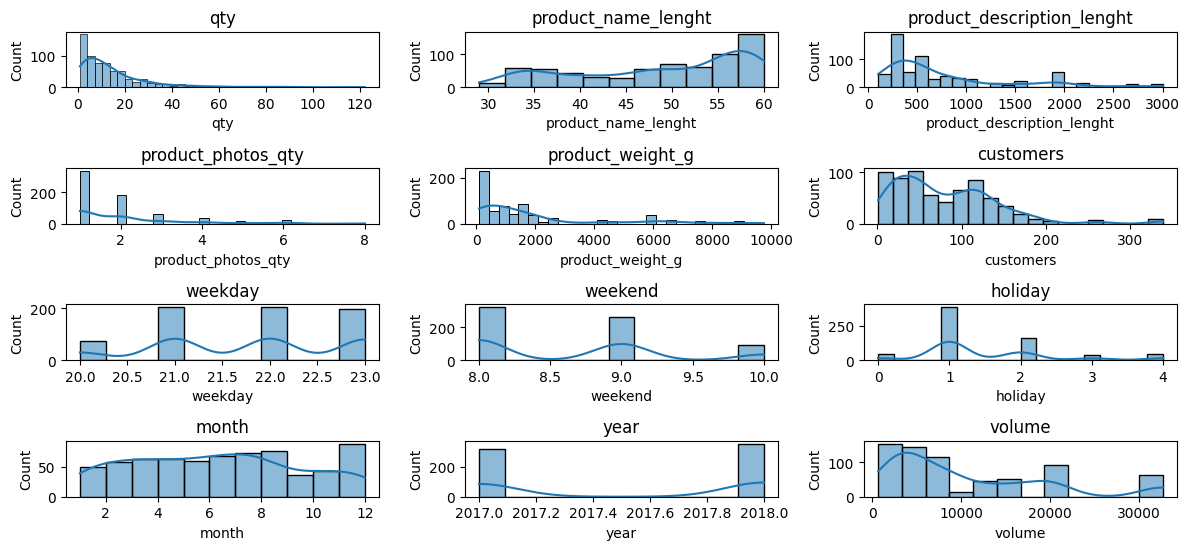

In [15]:
plt.figure(figsize=(12, 12))
plot_index = 1
for col in df_raw.select_dtypes("int"):
    plt.subplot(9, 3, plot_index)
    sns.histplot(df_raw[col], kde=True)
    plt.title(col)
    plot_index += 1
    plt.tight_layout()

In [17]:
df_clean = df_raw.copy()
target_cols = ["qty", "customers", "comp_1", "comp_3"]
for col in df_clean[target_cols]:
    q_low, q_high = df_clean[col].quantile([0.10, 0.90])
    iqr = q_high - q_low
    lower_bound, upper_bound = q_low - 1.5 * iqr, q_high + 1.5 * iqr
    if df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)].any(axis=None):
        print(f"{col} -> Outliers detected")
    else:
        print(f"{col} -> No outliers")

def find_outliers(series):
    q1, q3 = np.percentile(series, [10, 90])
    iqr = q3 - q1
    bounds = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)
    return [val for val in series if val < bounds[0] or val > bounds[1]]

print(find_outliers(df_raw.qty))
print(find_outliers(df_raw.comp_1))

qty -> Outliers detected
customers -> No outliers
comp_1 -> Outliers detected
comp_3 -> No outliers
[87, 91, 82, 85, 114, 76, 122, 83, 92]
[349.9, 349.9, 339.9]


In [18]:
for col in target_cols:
    ql, qh = df_clean[col].quantile([0.10, 0.90])
    iqr = qh - ql
    lower, upper = ql - 1.5 * iqr, qh + 1.5 * iqr
    df_clean[col] = np.where(df_clean[col] > upper, upper, df_clean[col])
    df_clean[col] = np.where(df_clean[col] < lower, lower, df_clean[col])

In [19]:
for col in target_cols:
    ql, qh = df_clean[col].quantile([0.10, 0.90])
    iqr = qh - ql
    lb, ub = ql - 1.5 * iqr, qh + 1.5 * iqr
    print(col, "yes" if df_clean[(df_clean[col] > ub) | (df_clean[col] < lb)].any().any() else "no")

qty no
customers no
comp_1 no
comp_3 no


In [20]:
df_raw["parsed_date"] = pd.to_datetime(df_raw["month_year"])
df_raw["day"] = df_raw["parsed_date"].dt.day

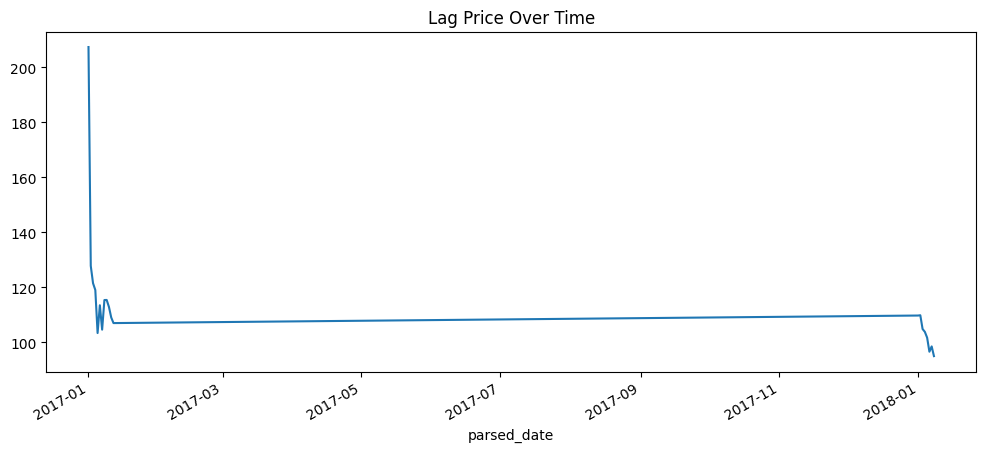

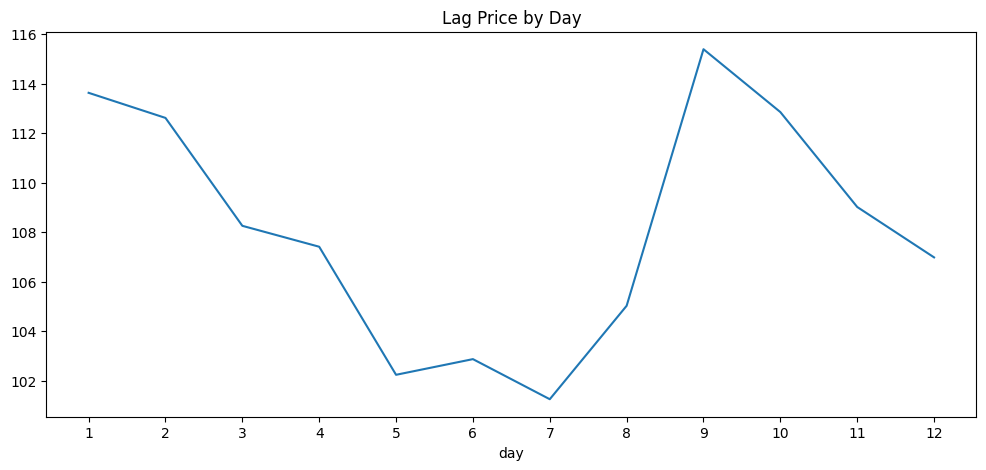

In [23]:
numeric_df_raw = df_raw.select_dtypes(include=np.number)
monthly_grp = numeric_df_raw.groupby(df_raw["parsed_date"]).mean()
plt.figure(figsize=(12, 5))
monthly_grp["lag_price"].plot(title="Lag Price Over Time")
plt.show()

daily_grp = numeric_df_raw.groupby(df_raw["day"]).mean()
plt.figure(figsize=(12, 5))
plt.xticks(ticks=range(1, 32))
daily_grp["lag_price"].plot(title="Lag Price by Day")
plt.show()

In [24]:
df_raw.drop("month_year", axis=1, inplace=True)
df_clean["parsed_date"] = pd.to_datetime(df_clean["month_year"])
df_clean["day"] = df_clean["parsed_date"].dt.day
df_clean.drop("month_year", axis=1, inplace=True)

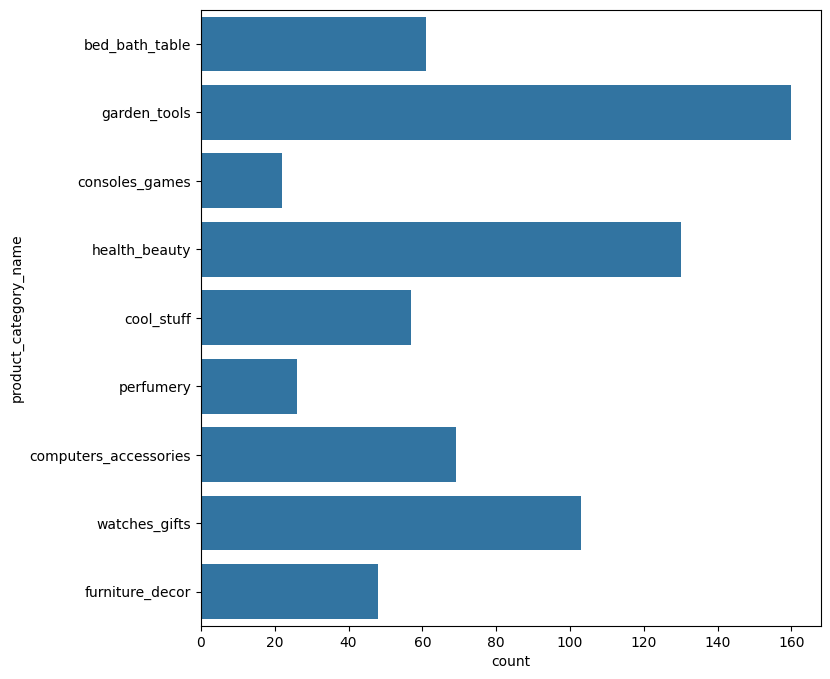

In [26]:
plt.figure(figsize=(8, 8))
sns.countplot(df_raw["product_category_name"])
plt.show()

array([[<Axes: title={'center': 'qty'}>,
        <Axes: title={'center': 'total_price'}>,
        <Axes: title={'center': 'freight_price'}>,
        <Axes: title={'center': 'unit_price'}>,
        <Axes: title={'center': 'product_name_lenght'}>],
       [<Axes: title={'center': 'product_description_lenght'}>,
        <Axes: title={'center': 'product_photos_qty'}>,
        <Axes: title={'center': 'product_weight_g'}>,
        <Axes: title={'center': 'product_score'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'weekday'}>,
        <Axes: title={'center': 'weekend'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 's'}>,
        <Axes: title={'center': 'volume'}>,
        <Axes: title={'center': 'comp_1'}>,
        <Axes: title={'center': 'ps1'}>, <Axes: title={'center': 'fp1'}>],
       [<Axes: title={'center': 'comp_2'}>,
        <Axes

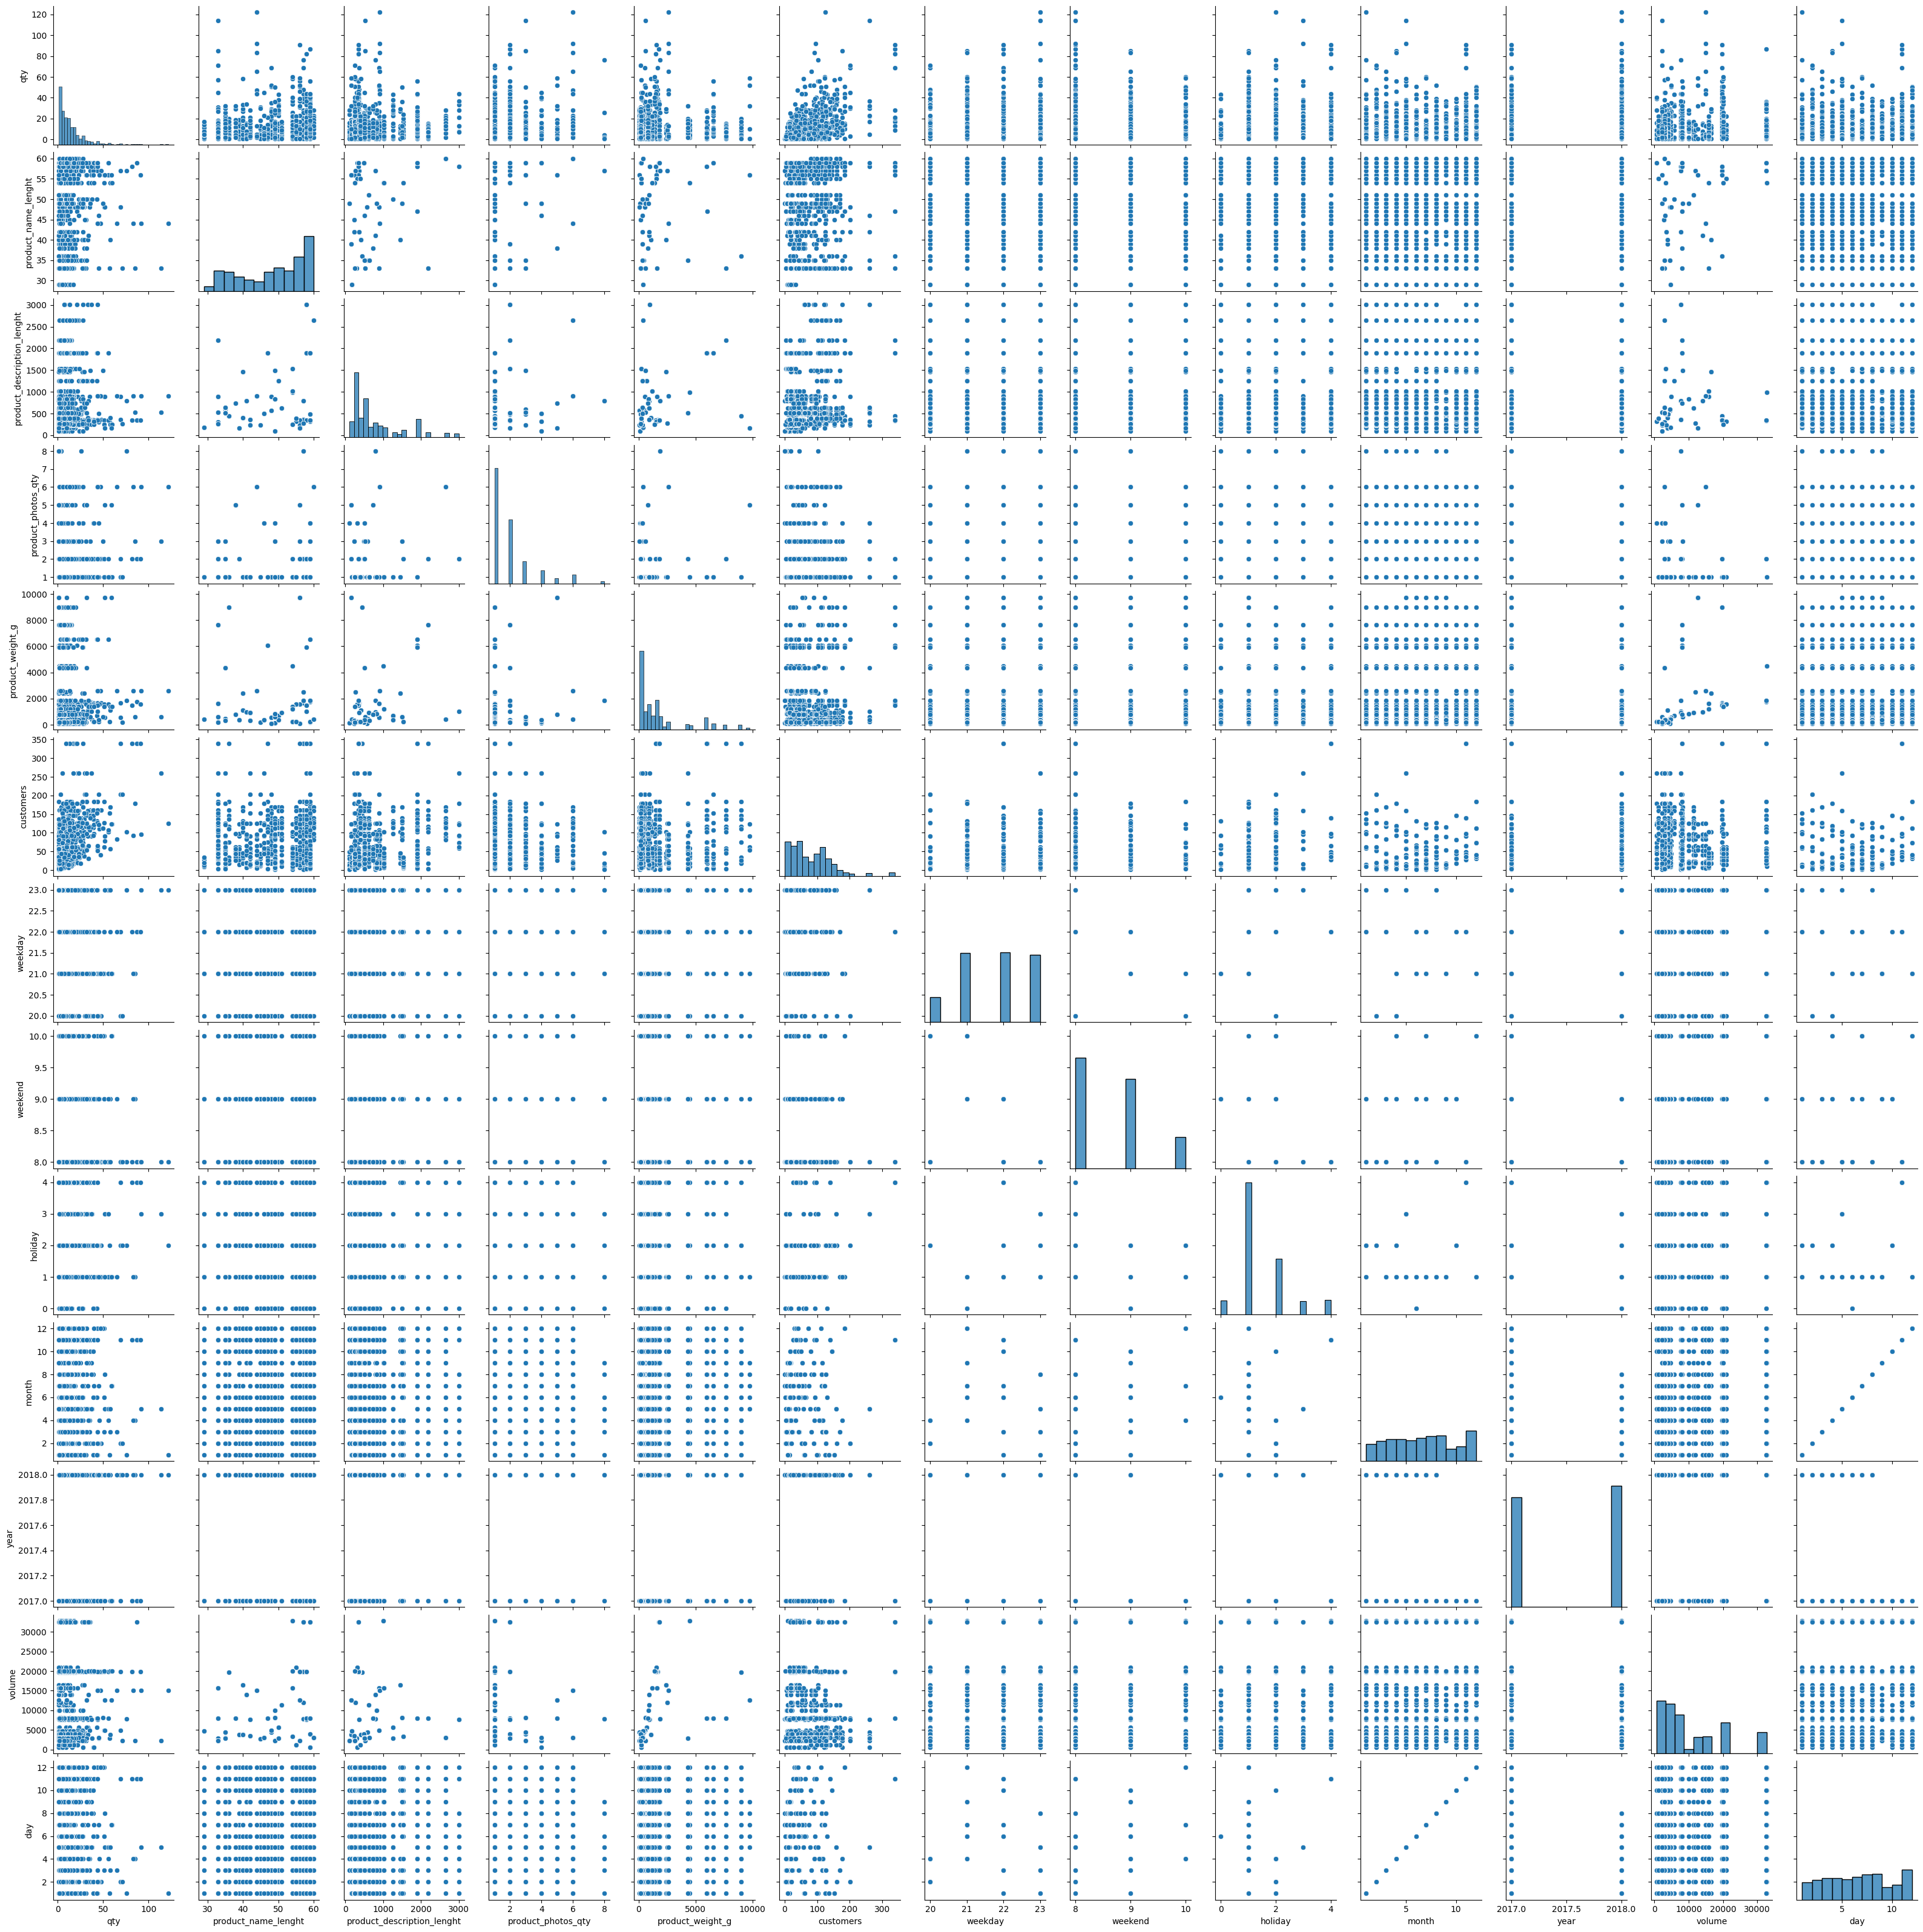

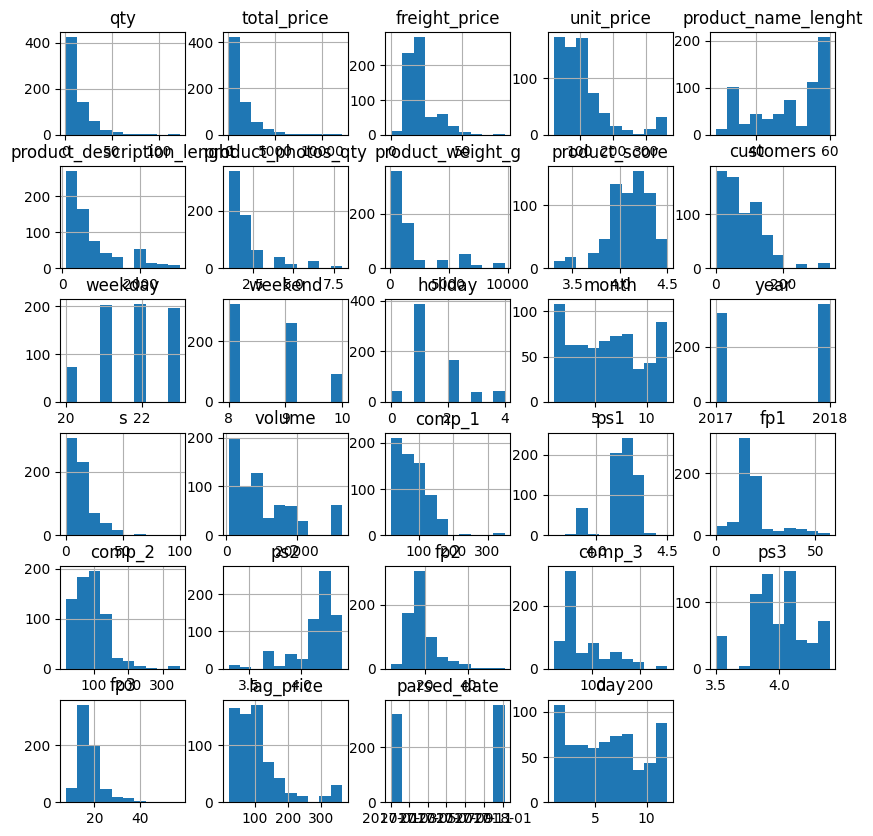

In [28]:
sns.pairplot(df_raw.select_dtypes("int"))
df_raw.hist(figsize=(10, 10))

In [29]:
category_dummies = pd.get_dummies(df_raw["product_category_name"])
df_raw.drop("product_category_name", axis=1, inplace=True)
df_raw = pd.concat([df_raw, category_dummies], axis=1)

category_dummies_clean = pd.get_dummies(df_clean["product_category_name"])
df_clean.drop("product_category_name", axis=1, inplace=True)
df_clean = pd.concat([df_clean, category_dummies_clean], axis=1)

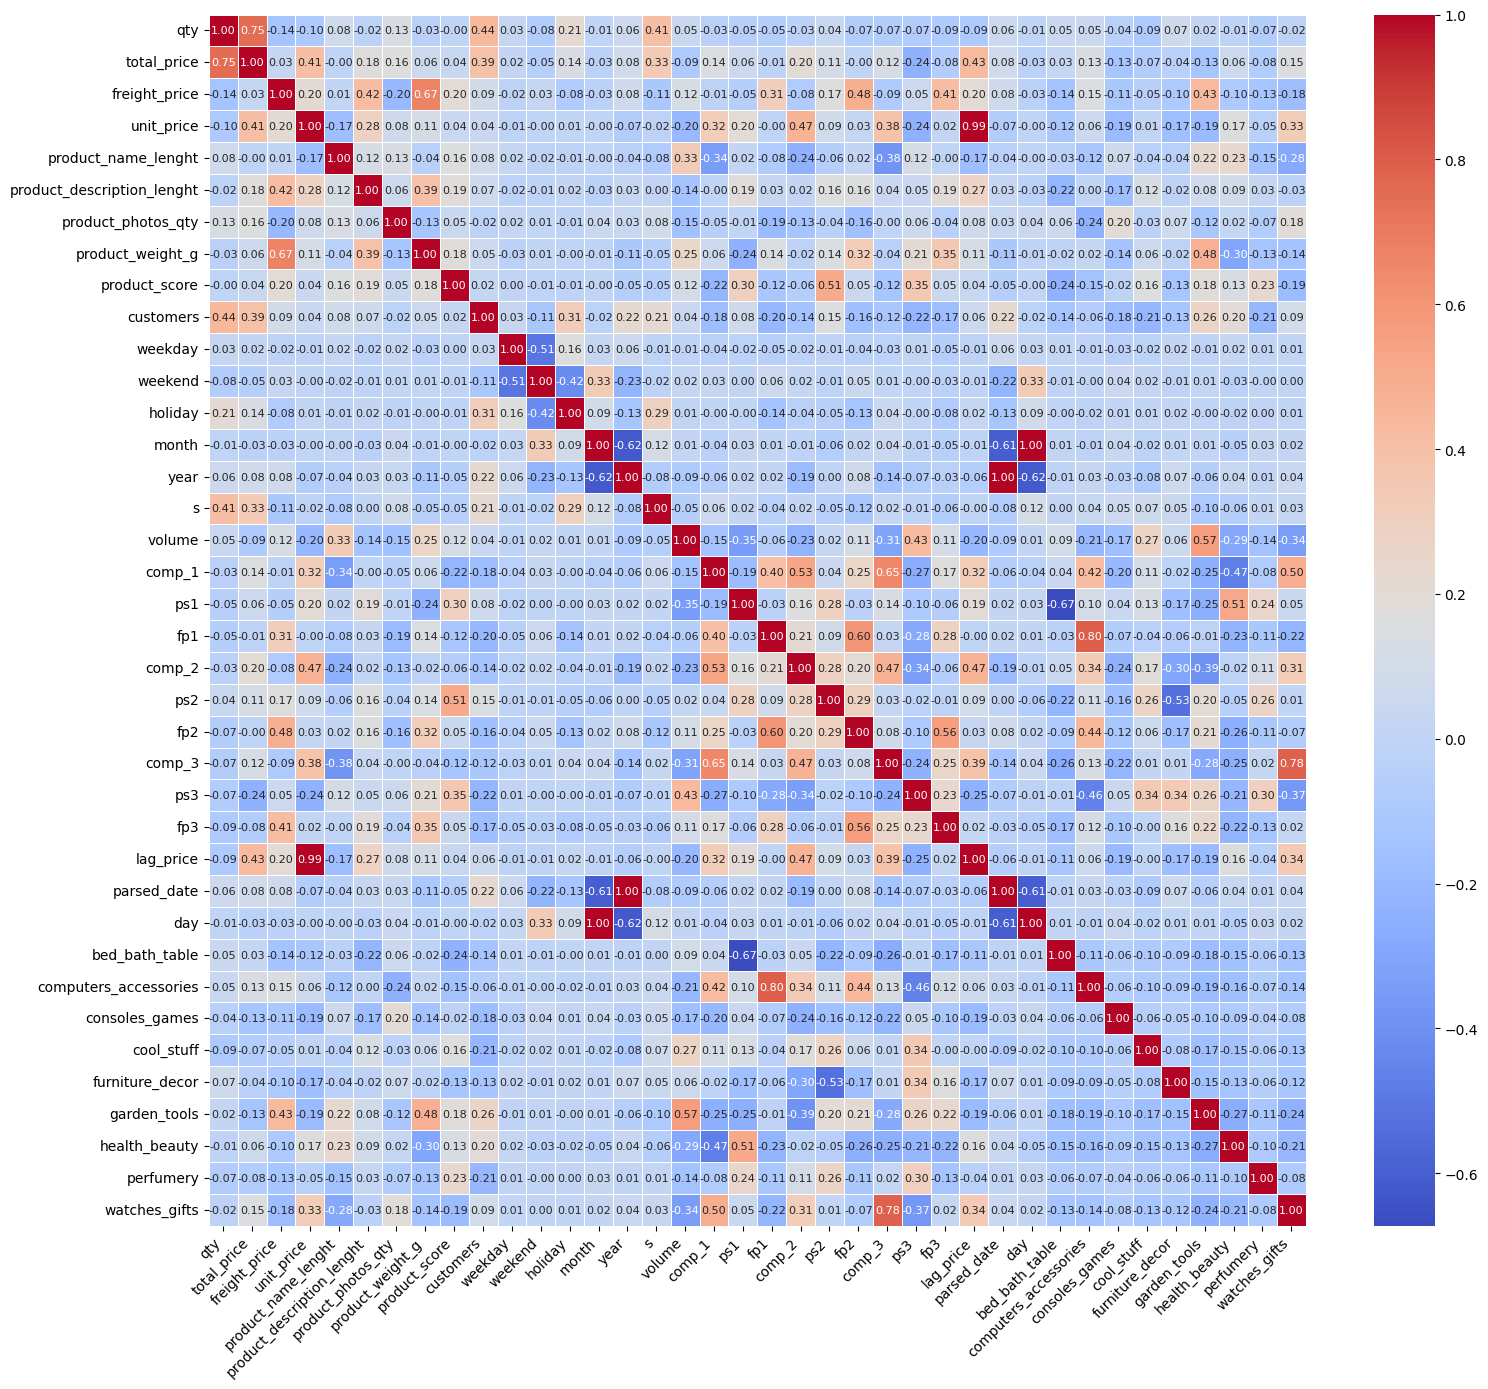

In [33]:
plt.figure(figsize=(16, 14))
sns.heatmap(
    df_raw.corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    annot_kws={"size": 8},
    linewidths=0.5
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [34]:
correlations = df_raw.corr()["lag_price"].sort_values(ascending=False)
print(pd.DataFrame({"Feature": correlations.index, "Correlation": correlations.values}))

                       Feature  Correlation
0                    lag_price     1.000000
1                   unit_price     0.994453
2                       comp_2     0.465271
3                  total_price     0.426256
4                       comp_3     0.385621
5                watches_gifts     0.335569
6                       comp_1     0.322348
7   product_description_lenght     0.273883
8                freight_price     0.201143
9                          ps1     0.194805
10               health_beauty     0.156513
11            product_weight_g     0.112790
12                         ps2     0.092632
13          product_photos_qty     0.075246
14       computers_accessories     0.064012
15                   customers     0.056988
16               product_score     0.035109
17                         fp2     0.032378
18                         fp3     0.021618
19                     holiday     0.021119
20                  cool_stuff    -0.000914
21                         fp1  

In [35]:
df_raw.drop(["unit_price", "day"], axis=1, inplace=True)
df_clean.drop(["unit_price", "day"], axis=1, inplace=True)

In [40]:
X_features = df_raw.drop(["lag_price", "parsed_date"], axis=1)
y_target = df_raw["lag_price"]
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=42)

In [41]:
models_list = [
    Ridge(), Lasso(), ElasticNet(), KNeighborsRegressor(), AdaBoostRegressor(),
    SVR(), MLPRegressor(), DecisionTreeRegressor(), RandomForestRegressor(),
    XGBRegressor(), GradientBoostingRegressor(), LGBMRegressor(), CatBoostRegressor(verbose=0)
]

In [42]:
def evaluate_model(trained_model):
    return trained_model.score(X_train, y_train)

for model in models_list:
    model.fit(X_train, y_train)
    print(f"{model.__class__.__name__}: Train Score = {evaluate_model(model):.4f}")

Ridge: Train Score = 0.7210
Lasso: Train Score = 0.6934
ElasticNet: Train Score = 0.6836
KNeighborsRegressor: Train Score = 0.8666
AdaBoostRegressor: Train Score = 0.9074
SVR: Train Score = 0.0390
MLPRegressor: Train Score = 0.7257
DecisionTreeRegressor: Train Score = 1.0000
RandomForestRegressor: Train Score = 0.9867
XGBRegressor: Train Score = 1.0000
GradientBoostingRegressor: Train Score = 0.9880
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 473, number of used features: 33
[LightGBM] [Info] Start training from score 107.736695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi